**google colab 환경에서 학습을 진행하였습니다.**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('./drive/MyDrive/news topic competition')

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
train_data=pd.read_csv('./data/train_data.csv')
topic_dict=pd.read_csv('./data/topic_dict.csv')

In [ ]:
train_data.head()

,index,title,topic_idx
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4


In [ ]:
topic_dict

,topic,topic_idx
0,IT과학,0
1,경제,1
2,사회,2
3,생활문화,3
4,세계,4
5,스포츠,5
6,정치,6


In [ ]:
train_data['topic_idx'].unique()

array([4, 6, 5, 0, 1, 3, 2])

In [ ]:
topic_dict['topic_idx'].unique()

array([0, 1, 2, 3, 4, 5, 6])

- label은 총 0 ~ 6으로 7개를 가지고 있다.

In [ ]:
train_data['topic_idx'].value_counts()

4    7629
2    7362
5    6933
6    6751
1    6222
3    5933
0    4824
Name: topic_idx, dtype: int64

- label은 대체로 골고루 존재한다.

In [ ]:
!pip install transformers==4.2.0 sentencepiece

In [ ]:
import torch

from sklearn.metrics import accuracy_score
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, Trainer, TrainingArguments, XLMRobertaConfig
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

In [ ]:
data=pd.read_csv('./data/train_data.csv')

# 확인용 데이터 저장
#data.to_csv('train_for_confirmation.csv',index=False,encoding='utf-8-sig')

In [ ]:
def tokenized_dataset(dataset, tokenizer):
    tokenized_sentences = tokenizer(
      list(dataset['title']),
      return_tensors="pt",
      padding=True,
      truncation=True,
      max_length=44
      )
    return tokenized_sentences

In [ ]:
# Dataset 구성.
class news_Dataset(torch.utils.data.Dataset):
    def __init__(self, tokenized_dataset, labels):
        self.tokenized_dataset = tokenized_dataset
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.tokenized_dataset.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
    
    def get_classes(self):
        return self.labels

In [ ]:
# load model and tokenizer
MODEL_NAME = "xlm-roberta-large"
tokenizer = XLMRobertaTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
# 기본 20% val set구성
train_dataset,val_dataset = train_test_split(data,test_size=0.2,stratify=data['topic_idx'],random_state=42)

train_label=train_dataset['topic_idx'].values
val_label=val_dataset['topic_idx'].values

In [ ]:
# tokenizing dataset
tokenized_train = tokenized_dataset(train_dataset, tokenizer)
tokenized_val = tokenized_dataset(val_dataset, tokenizer)

In [ ]:
# make dataset for pytorch.
news_train_dataset = news_Dataset(tokenized_train, train_label)
news_val_dataset = news_Dataset(tokenized_val, val_label)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
# setting model hyperparameter
bert_config = XLMRobertaConfig.from_pretrained(MODEL_NAME)
bert_config.num_labels = 7
model = XLMRobertaForSequenceClassification.from_pretrained(MODEL_NAME, config=bert_config)
model.to(device)

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.den

XLMRobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(250002, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
     

In [ ]:
# 파라미터
epochs=10
lr=1e-5
batch_size=32

In [ ]:
from packaging import version
# doc에서의 조건들
if isinstance(train_dataset, torch.utils.data.dataset.IterableDataset) :
    print('yes')
else:
    print('no')

if version.parse(torch.__version__) >= version.parse("1.6"):
    print('if _is_torch_generator_available is True,\n Use RandomSampler(self.train_dataset, generator=generator)')

no
if _is_torch_generator_available is True,
 Use RandomSampler(self.train_dataset, generator=generator)


In [ ]:
#https://github.com/huggingface/transformers/blob/83e5a10603ca902c266e40fc98a01dd8a9b04ac4/src/transformers/data/data_collator.py#L38
from typing import Any, Callable, Dict, List, NewType, Optional, Tuple, Union
InputDataClass = NewType("InputDataClass", Any)

def default_data_collator(features: List[InputDataClass]) -> Dict[str, torch.Tensor]:
    """
    Very simple data collator that simply collates batches of dict-like objects and performs special handling for
    potential keys named:
        - ``label``: handles a single value (int or float) per object
        - ``label_ids``: handles a list of values per object
    Does not do any additional preprocessing: property names of the input object will be used as corresponding inputs
    to the model. See glue and ner for example of how it's useful.
    """

    # In this function we'll make the assumption that all `features` in the batch
    # have the same attributes.
    # So we will look at the first element as a proxy for what attributes exist
    # on the whole batch.

    # if not isinstance(features[0], (dict, BatchEncoding)):
    #     features = [vars(f) for f in features]

    #features = [vars(f) for f in features]
    first = features[0]
    batch = {}

    # Special handling for labels.
    # Ensure that tensor is created with the correct type
    # (it should be automatically the case, but let's make sure of it.)
    if "label" in first and first["label"] is not None:
        label = first["label"].item() if isinstance(first["label"], torch.Tensor) else first["label"]
        dtype = torch.long if isinstance(label, int) else torch.float
        batch["labels"] = torch.tensor([f["label"] for f in features], dtype=dtype)
    elif "label_ids" in first and first["label_ids"] is not None:
        if isinstance(first["label_ids"], torch.Tensor):
            batch["labels"] = torch.stack([f["label_ids"] for f in features])
        else:
            dtype = torch.long if type(first["label_ids"][0]) is int else torch.float
            batch["labels"] = torch.tensor([f["label_ids"] for f in features], dtype=dtype)

    # Handling of all other possible keys.
    # Again, we will use the first element to figure out which key/values are not None for this model.
    for k, v in first.items():
        if k not in ("label", "label_ids") and v is not None and not isinstance(v, str):    # str을 넣어준다.
            if isinstance(v, torch.Tensor):
                batch[k] = torch.stack([f[k] for f in features])
            else:
                batch[k] = torch.tensor([f[k] for f in features])

    return batch

In [ ]:
from torch import nn

from torch.optim import Optimizer
from typing import Callable, Iterable, Optional, Tuple, Union

# https://github.com/huggingface/transformers/blob/83e5a10603ca902c266e40fc98a01dd8a9b04ac4/src/transformers/optimization.py#L271
class AdamW(Optimizer):
    """
    Implements Adam algorithm with weight decay fix as introduced in `Decoupled Weight Decay Regularization
    <https://arxiv.org/abs/1711.05101>`__.
    Parameters:
        params (:obj:`Iterable[nn.parameter.Parameter]`):
            Iterable of parameters to optimize or dictionaries defining parameter groups.
        lr (:obj:`float`, `optional`, defaults to 1e-3):
            The learning rate to use.
        betas (:obj:`Tuple[float,float]`, `optional`, defaults to (0.9, 0.999)):
            Adam's betas parameters (b1, b2).
        eps (:obj:`float`, `optional`, defaults to 1e-6):
            Adam's epsilon for numerical stability.
        weight_decay (:obj:`float`, `optional`, defaults to 0):
            Decoupled weight decay to apply.
        correct_bias (:obj:`bool`, `optional`, defaults to `True`):
            Whether or not to correct bias in Adam (for instance, in Bert TF repository they use :obj:`False`).
    """

    def __init__(
        self,
        params: Iterable[nn.parameter.Parameter],
        lr: float = 1e-3,
        betas: Tuple[float, float] = (0.9, 0.999),
        eps: float = 1e-6,
        weight_decay: float = 0.0,
        correct_bias: bool = True,
    ):
        #require_version("torch>=1.5.0")  # add_ with alpha
        if lr < 0.0:
            raise ValueError(f"Invalid learning rate: {lr} - should be >= 0.0")
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError(f"Invalid beta parameter: {betas[0]} - should be in [0.0, 1.0[")
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError(f"Invalid beta parameter: {betas[1]} - should be in [0.0, 1.0[")
        if not 0.0 <= eps:
            raise ValueError(f"Invalid epsilon value: {eps} - should be >= 0.0")
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, correct_bias=correct_bias)
        super().__init__(params, defaults)

    def step(self, closure: Callable = None):
        """
        Performs a single optimization step.
        Arguments:
            closure (:obj:`Callable`, `optional`): A closure that reevaluates the model and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError("Adam does not support sparse gradients, please consider SparseAdam instead")

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state["step"] = 0
                    # Exponential moving average of gradient values
                    state["exp_avg"] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state["exp_avg_sq"] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state["exp_avg"], state["exp_avg_sq"]
                beta1, beta2 = group["betas"]

                state["step"] += 1

                # Decay the first and second moment running average coefficient
                # In-place operations to update the averages at the same time
                exp_avg.mul_(beta1).add_(grad, alpha=(1.0 - beta1))
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1.0 - beta2)
                denom = exp_avg_sq.sqrt().add_(group["eps"])

                step_size = group["lr"]
                if group["correct_bias"]:  # No bias correction for Bert
                    bias_correction1 = 1.0 - beta1 ** state["step"]
                    bias_correction2 = 1.0 - beta2 ** state["step"]
                    step_size = step_size * math.sqrt(bias_correction2) / bias_correction1

                p.data.addcdiv_(exp_avg, denom, value=-step_size)

                # Just adding the square of the weights to the loss function is *not*
                # the correct way of using L2 regularization/weight decay with Adam,
                # since that will interact with the m and v parameters in strange ways.
                #
                # Instead we want to decay the weights in a manner that doesn't interact
                # with the m/v parameters. This is equivalent to adding the square
                # of the weights to the loss with plain (non-momentum) SGD.
                # Add weight decay at the end (fixed version)
                if group["weight_decay"] > 0.0:
                    p.data.add_(p.data, alpha=(-group["lr"] * group["weight_decay"]))

        return loss

In [ ]:
def get_parameter_names(model, forbidden_layer_types):
    """
    Returns the names of the model parameters that are not inside a forbidden layer.
    """
    result = []
    for name, child in model.named_children():
        result += [
            f"{name}.{n}"
            for n in get_parameter_names(child, forbidden_layer_types)
            if not isinstance(child, tuple(forbidden_layer_types))
        ]
    # Add model specific parameters (defined with nn.Parameter) since they are not in any child.
    result += list(model._parameters.keys())
    return result

In [ ]:
def create_optimizer(model):
        """
        Setup the optimizer.

        We provide a reasonable default that works well. If you want to use something else, you can pass a tuple in the
        Trainer's init through :obj:`optimizers`, or subclass and override this method in a subclass.
        """
        decay_parameters = get_parameter_names(model, [nn.LayerNorm])
        decay_parameters = [name for name in decay_parameters if "bias" not in name]
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in model.named_parameters() if n in decay_parameters],
                "weight_decay": 0.01,
            },
            {
                "params": [p for n, p in model.named_parameters() if n not in decay_parameters],
                "weight_decay": 0.0,
            },
        ]

        optimizer_cls = AdamW
        optimizer_kwargs = {
            "betas": (0.9, 0.999),
            "eps": 1e-8,
        }
        optimizer_kwargs["lr"] = lr
        return optimizer_cls(optimizer_grouped_parameters, **optimizer_kwargs)

In [ ]:
from torch.optim.lr_scheduler import LambdaLR

def get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps, last_epoch=-1):
    """
    Create a schedule with a learning rate that decreases linearly from the initial lr set in the optimizer to 0, after
    a warmup period during which it increases linearly from 0 to the initial lr set in the optimizer.
    Args:
        optimizer (:class:`~torch.optim.Optimizer`):
            The optimizer for which to schedule the learning rate.
        num_warmup_steps (:obj:`int`):
            The number of steps for the warmup phase.
        num_training_steps (:obj:`int`):
            The total number of training steps.
        last_epoch (:obj:`int`, `optional`, defaults to -1):
            The index of the last epoch when resuming training.
    Return:
        :obj:`torch.optim.lr_scheduler.LambdaLR` with the appropriate schedule.
    """

    def lr_lambda(current_step: int):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        return max(
            0.0, float(num_training_steps - current_step) / float(max(1, num_training_steps - num_warmup_steps))
        )

    return LambdaLR(optimizer, lr_lambda, last_epoch)

In [ ]:
# loss
from dataclasses import dataclass

@dataclass
class LabelSmoother:
    """
    Adds label-smoothing on a pre-computed output from a Transformers model.
    Args:
        epsilon (:obj:`float`, `optional`, defaults to 0.1):
            The label smoothing factor.
        ignore_index (:obj:`int`, `optional`, defaults to -100):
            The index in the labels to ignore when computing the loss.
    """

    epsilon: float = 0.1
    ignore_index: int = -100

    def __call__(self, model_output, labels):
        logits = model_output["logits"] if isinstance(model_output, dict) else model_output[0]
        log_probs = -nn.functional.log_softmax(logits, dim=-1)
        if labels.dim() == log_probs.dim() - 1:
            labels = labels.unsqueeze(-1)

        padding_mask = labels.eq(self.ignore_index)
        # In case the ignore_index is -100, the gather will fail, so we replace labels by 0. The padding_mask
        # will ignore them in any case.
        labels.clamp_min_(0)
        nll_loss = log_probs.gather(dim=-1, index=labels)
        # works for fp16 input tensor too, by internally upcasting it to fp32
        smoothed_loss = log_probs.sum(dim=-1, keepdim=True, dtype=torch.float32)

        nll_loss.masked_fill_(padding_mask, 0.0)
        smoothed_loss.masked_fill_(padding_mask, 0.0)

        # Take the mean over the label dimensions, then divide by the number of active elements (i.e. not-padded):
        num_active_elements = padding_mask.numel() - padding_mask.long().sum()
        nll_loss = nll_loss.sum() / num_active_elements
        smoothed_loss = smoothed_loss.sum() / (num_active_elements * log_probs.shape[-1])
        return (1 - self.epsilon) * nll_loss + self.epsilon * smoothed_loss

In [ ]:
import math

from torch.utils.data import DataLoader
from torch.utils.data.sampler import RandomSampler, SequentialSampler
from tqdm import tqdm

# https://huggingface.co/transformers/_modules/transformers/trainer.html#Trainer

# loader에 필요한 인자들
data_collator = default_data_collator

# sampler에 사용 인자 
generator = torch.Generator()
generator.manual_seed(int(torch.empty((), dtype=torch.int64).random_().item()))

# sampler 정의
train_sampler=RandomSampler(train_dataset, generator=generator)
eval_sampler= SequentialSampler(val_dataset)

train_dataloader = DataLoader(
            news_train_dataset,
            batch_size=batch_size,
            sampler= train_sampler,
            collate_fn= data_collator,
            drop_last=False,
            num_workers=4,
            pin_memory=True,
        )
val_dataloader = DataLoader(
            news_val_dataset,
            batch_size=batch_size,
            sampler=eval_sampler,
            collate_fn= data_collator,
            drop_last=False,
            num_workers=4,
            pin_memory=True,
        )

num_update_steps_per_epoch = max(len(train_dataloader), 1)
max_steps = math.ceil(epochs * num_update_steps_per_epoch)

# criterion, optimizer, scheduler 설정
criterion=LabelSmoother(epsilon=0.2)
optimizer = create_optimizer(model)
scheduler = get_linear_schedule_with_warmup(
        optimizer=optimizer,
        num_warmup_steps=5000,
        num_training_steps=max_steps
    )

In [ ]:
def ids_to_string(ids_list):
  return tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(ids_list,skip_special_tokens=True))

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

print_step=250
print ("Start training.\n")
for epoch in tqdm(range(epochs)):
    print(f'{epoch+1} epoch Training...')
    # train mode
    model.train()
    train_loss=0
    train_acc=0
    val_loss=0
    val_acc=0

    for step, inputs in enumerate(train_dataloader):
        outputs = model(
              input_ids=inputs['input_ids'].to(device),
              attention_mask=inputs['attention_mask'].to(device)
              )
        
        loss = criterion(outputs,inputs['labels'].to(device))

        optimizer.zero_grad() # reset gradient 
        loss.backward() # back propagation  
        optimizer.step() # parameters update
        scheduler.step() # scheduler step
        
        labels = inputs['labels'].detach().cpu().numpy()
        preds = outputs['logits'].argmax(-1).detach().cpu().numpy()

        # 정확도 계산
        train_acc += sum(labels == preds)

        # loss 계산
        train_loss += loss.item() * inputs['input_ids'].shape[0]

        # step 주기에 따른 loss 출력
        if (step + 1) % print_step == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Step [{step+1}/{len(train_dataloader)}], Loss: {loss.item():.2f}, acc: {train_acc/((step+1)*batch_size):.4f}')
    
    # metric 계산
    train_loss = train_loss / len(news_train_dataset)
    train_acc = train_acc / len(news_train_dataset)

    # val mode
    print ("Start validation.\n")
    model.eval()

    # 잘못 예측한 데이터 저장
    err_data={'title':[],'preds':[],'labels':[]}
    with torch.no_grad():
        for step, inputs in enumerate(val_dataloader):
            outputs = model(
              input_ids=inputs['input_ids'].to(device),
              attention_mask=inputs['attention_mask'].to(device)
              )
        
            loss = criterion(outputs,inputs['labels'].to(device))
            
            labels = inputs['labels'].detach().cpu().numpy()
            preds = outputs['logits'].argmax(-1).detach().cpu().numpy()

            # 정확도 계산
            val_acc += sum(labels == preds)

            # loss 계산
            val_loss += loss.item() * inputs['input_ids'].shape[0]

            # csv 만들기
            ids_list=inputs['input_ids'][~(labels == preds)].detach().cpu().numpy()
            err_data['title'].extend(list(map(ids_to_string,ids_list)))
            err_data['preds'].extend(preds[~(labels == preds)])
            err_data['labels'].extend(labels[~(labels == preds)])

        # metric 계산
        val_loss = val_loss / len(news_val_dataset)
        val_acc = val_acc / len(news_val_dataset)
    print('err_data Save...')
    pd.DataFrame(err_data).to_csv(f'./results/err_data{epoch+1}.csv',encoding='utf-8-sig',index=False)
    print(f'Epoch: [{epoch+1}] Train Loss: [{train_loss:.4f}] Train Acc: [{train_acc:.4f}] Val Loss: [{val_loss:.4f}] Val Acc:[{val_acc:.4f}] ')


  0%|          | 0/10 [00:00<?, ?it/s]

Start training.

1 epoch Training...
Epoch [1/10], Step [250/1142], Loss: 1.03, acc: 0.8625
Epoch [1/10], Step [500/1142], Loss: 1.08, acc: 0.8666
Epoch [1/10], Step [750/1142], Loss: 1.21, acc: 0.8682
Epoch [1/10], Step [1000/1142], Loss: 0.88, acc: 0.8683
Start validation.




 10%|█         | 1/10 [09:20<1:24:05, 560.59s/it]

err_data Save...
Epoch: [1] Train Loss: [0.9979] Train Acc: [0.8690] Val Loss: [0.9718] Val Acc:[0.8833] 
2 epoch Training...
Epoch [2/10], Step [250/1142], Loss: 0.95, acc: 0.8851
Epoch [2/10], Step [500/1142], Loss: 1.03, acc: 0.8829
Epoch [2/10], Step [750/1142], Loss: 0.94, acc: 0.8821
Epoch [2/10], Step [1000/1142], Loss: 1.00, acc: 0.8815
Start validation.




 20%|██        | 2/10 [18:40<1:14:43, 560.49s/it]

err_data Save...
Epoch: [2] Train Loss: [0.9721] Train Acc: [0.8820] Val Loss: [0.9632] Val Acc:[0.8852] 
3 epoch Training...
Epoch [3/10], Step [250/1142], Loss: 0.97, acc: 0.8948
Epoch [3/10], Step [500/1142], Loss: 1.10, acc: 0.8948
Epoch [3/10], Step [750/1142], Loss: 1.04, acc: 0.8937
Epoch [3/10], Step [1000/1142], Loss: 1.05, acc: 0.8898
Start validation.




 30%|███       | 3/10 [28:00<1:05:22, 560.39s/it]

err_data Save...
Epoch: [3] Train Loss: [0.9585] Train Acc: [0.8901] Val Loss: [0.9601] Val Acc:[0.8879] 
4 epoch Training...
Epoch [4/10], Step [250/1142], Loss: 0.81, acc: 0.9075
Epoch [4/10], Step [500/1142], Loss: 0.95, acc: 0.9042
Epoch [4/10], Step [750/1142], Loss: 0.90, acc: 0.9045
Epoch [4/10], Step [1000/1142], Loss: 0.95, acc: 0.9025
Start validation.




 40%|████      | 4/10 [37:21<56:01, 560.29s/it]  

err_data Save...
Epoch: [4] Train Loss: [0.9360] Train Acc: [0.9022] Val Loss: [0.9572] Val Acc:[0.8892] 
5 epoch Training...
Epoch [5/10], Step [250/1142], Loss: 0.91, acc: 0.9180
Epoch [5/10], Step [500/1142], Loss: 0.84, acc: 0.9185
Epoch [5/10], Step [750/1142], Loss: 0.86, acc: 0.9166
Epoch [5/10], Step [1000/1142], Loss: 0.93, acc: 0.9163
Start validation.




 50%|█████     | 5/10 [46:41<46:41, 560.22s/it]

err_data Save...
Epoch: [5] Train Loss: [0.9127] Train Acc: [0.9166] Val Loss: [0.9589] Val Acc:[0.8907] 
6 epoch Training...
Epoch [6/10], Step [250/1142], Loss: 0.86, acc: 0.9364
Epoch [6/10], Step [500/1142], Loss: 0.80, acc: 0.9346
Epoch [6/10], Step [750/1142], Loss: 0.91, acc: 0.9308
Epoch [6/10], Step [1000/1142], Loss: 0.83, acc: 0.9313
Start validation.




 60%|██████    | 6/10 [56:01<37:20, 560.21s/it]

err_data Save...
Epoch: [6] Train Loss: [0.8876] Train Acc: [0.9318] Val Loss: [0.9638] Val Acc:[0.8897] 
7 epoch Training...
Epoch [7/10], Step [250/1142], Loss: 0.91, acc: 0.9479
Epoch [7/10], Step [500/1142], Loss: 0.85, acc: 0.9481
Epoch [7/10], Step [750/1142], Loss: 0.80, acc: 0.9481
Epoch [7/10], Step [1000/1142], Loss: 1.01, acc: 0.9477
Start validation.




 70%|███████   | 7/10 [1:05:21<28:00, 560.30s/it]

err_data Save...
Epoch: [7] Train Loss: [0.8643] Train Acc: [0.9467] Val Loss: [0.9676] Val Acc:[0.8909] 
8 epoch Training...
Epoch [8/10], Step [250/1142], Loss: 0.79, acc: 0.9587
Epoch [8/10], Step [500/1142], Loss: 0.92, acc: 0.9583
Epoch [8/10], Step [750/1142], Loss: 0.87, acc: 0.9594
Epoch [8/10], Step [1000/1142], Loss: 0.85, acc: 0.9595
Start validation.




 80%|████████  | 8/10 [1:14:42<18:40, 560.35s/it]

err_data Save...
Epoch: [8] Train Loss: [0.8437] Train Acc: [0.9591] Val Loss: [0.9749] Val Acc:[0.8876] 
9 epoch Training...
Epoch [9/10], Step [250/1142], Loss: 0.80, acc: 0.9692
Epoch [9/10], Step [500/1142], Loss: 0.84, acc: 0.9679
Epoch [9/10], Step [750/1142], Loss: 0.94, acc: 0.9690
Epoch [9/10], Step [1000/1142], Loss: 0.79, acc: 0.9688
Start validation.




 90%|█████████ | 9/10 [1:24:02<09:20, 560.45s/it]

err_data Save...
Epoch: [9] Train Loss: [0.8294] Train Acc: [0.9689] Val Loss: [0.9788] Val Acc:[0.8879] 
10 epoch Training...
Epoch [10/10], Step [250/1142], Loss: 0.80, acc: 0.9694
Epoch [10/10], Step [500/1142], Loss: 0.77, acc: 0.9722
Epoch [10/10], Step [750/1142], Loss: 0.79, acc: 0.9722
Epoch [10/10], Step [1000/1142], Loss: 0.86, acc: 0.9716
Start validation.




100%|██████████| 10/10 [1:33:23<00:00, 560.35s/it]

err_data Save...
Epoch: [10] Train Loss: [0.8241] Train Acc: [0.9714] Val Loss: [0.9788] Val Acc:[0.8879] 


## err file 확인하기
- 모델이 정답 label말고 어떠한 label로 예측했는지 시각화

In [ ]:
# 나눔 고딕 install
!apt-get update -qq
!apt-get install fonts-nanum* -qq

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm  # 폰트 관련 용도

sns.set_theme(style="darkgrid")

# 시스템에 설치된 폰트 확인
sys_font=fm.findSystemFonts()
print(f"sys_font number: {len(sys_font)}")
print(sys_font)

nanum_font = [f for f in sys_font if 'Nanum' in f]
print(f"nanum_font number: {len(nanum_font)}")

In [ ]:
# 폰트 개수 확인
sys_font=fm.findSystemFonts()
print(f"sys_font number: {len(sys_font)}")

nanum_font = [f for f in sys_font if 'Nanum' in f]
print(f"nanum_font number: {len(nanum_font)}")

In [ ]:
# 설치 된것중 하나 선택
path = '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf'  # 설치된 나눔글꼴중 원하는 녀석의 전체 경로를 가져오자
font_name = fm.FontProperties(fname=path, size=10).get_name()

# 우선 fm._rebuild()
fm._rebuild()

print(font_name)
plt.rc('font', family=font_name)

In [ ]:
err=pd.read_csv('./results/err_data7.csv')

In [ ]:
err['labels'].value_counts()

2    349
1    191
3    126
0    120
6    115
4     95
5     28
Name: labels, dtype: int64

In [ ]:
topic=pd.read_csv('./data/topic_dict.csv')

In [ ]:
topic

,topic,topic_idx
0,IT과학,0
1,경제,1
2,사회,2
3,생활문화,3
4,세계,4
5,스포츠,5
6,정치,6


In [ ]:
topic_dict={col['topic_idx']: col['topic'] for index,col in topic.iterrows()}

In [ ]:
def idx_to_topic(x):
  x['preds']=topic_dict[x['preds']]
  x['labels']=topic_dict[x['labels']]
  return x

err=err.apply(idx_to_topic, axis=1)

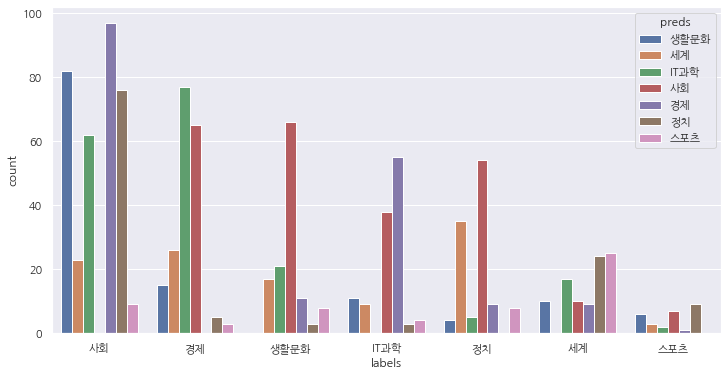

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(x="labels",hue='preds', data=err)

In [ ]:
err.head(50)

,title,preds,labels
0,방송소식 EBS 방을 구해드립니다 내일 첫 방송 外,생활문화,사회
1,美 금리인상 속도전 우려에 원달러 환율 14.2원 급등,세계,경제
2,넷플릭스 CCO 한국 콘텐츠 코로나 예방하며 제작,IT과학,생활문화
3,SNS돋보기 이통3사 통신비 인하 반대...대기업 횡포 비판,사회,IT과학
4,에쓰오일 여성고객 대상 구도일패밀리 응원이벤트,사회,생활문화
5,영암 월출산 국립공원 지정 30주년 기념식,생활문화,사회
6,한산한 대학 캠퍼스,생활문화,사회
7,LG화학 등 120개 상장사 3월 셋째주 정기 주총,경제,사회
8,일본에 빠진 한국인...일본 방문 해외관광객에서 중국 제치고 1위,생활문화,사회
9,현대카드 2531일 유명 레스토랑 50% 할인 고메위크,생활문화,경제
